In [1]:
import sys
sys.path.append("/home/imglab/Yi_Zhu/Smart_Project_v10/")
import os
from digital_network import *
from digital_unit import *
from optical_network import *
from optical_unit import *
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from new_shapes_dataset import TwoPaddedRotationShapesDataset
import matplotlib.pyplot as plt
import pickle
from model_retrieve_utils import *
from utils import *
import math

/home/imglab/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# hyperparameters for cnn layer
in_c = 1
out_c = 4      # kernels 
fc_in = out_c

# optical parameter
system_dim = 200
canvas_dim = system_dim // 4
phase_dim = 200
pixel_size = 9.2e-6
focal_length = 20e-3    #  200e-3  # 14.5e-2
wave_lambda = 795e-9

rows = 2
cols = 2

# hyperparameters for training and testing set
max_epochs = 300
lr=0.001

num_training_set = 50000
num_testing_set = 10000
shape_size = 0
dimension = 200
canvas_color = 0
fill = 1

In [3]:
# saving configurations
server_dir = "/home/imglab/Yi_Zhu/Smart_Project_v10/"
sub_dir = "results/"
dateinfo = "Mar_04_2024_23_35_33/"

model_folder = server_dir + sub_dir + dateinfo +'saved_onn_finetune_models/'
curve_folder = server_dir + sub_dir + dateinfo +'saved_finetune_training_curves/'

model_file_name = "fine_tune_onn_4kernel_ep50_lrp001_focal20mm.pt"
curve_file_name = "fine_tune_onn_4kernel_ep50_lrp001_focal20mm.pickle"

MODEL_PATH = model_folder + model_file_name
CURVE_PATH = curve_folder + curve_file_name

In [4]:
digital_model = DigitalCNN(in_c, out_c, fc_in)
optical_model = FourierConvComplex(system_dim, phase_dim, pixel_size, focal_length, wave_lambda)

onn = optical_model
fc = digital_model.classifier
dr = DetectorLayer(canvas_dim, rows, cols)
sensor = Sensor()   # convert complex field into intensity

model = OpticalConvModel(onn, fc, dr, sensor)
model.load_state_dict(torch.load(f=MODEL_PATH))

<All keys matched successfully>

In [5]:
# extract onn model
onn = model.onn

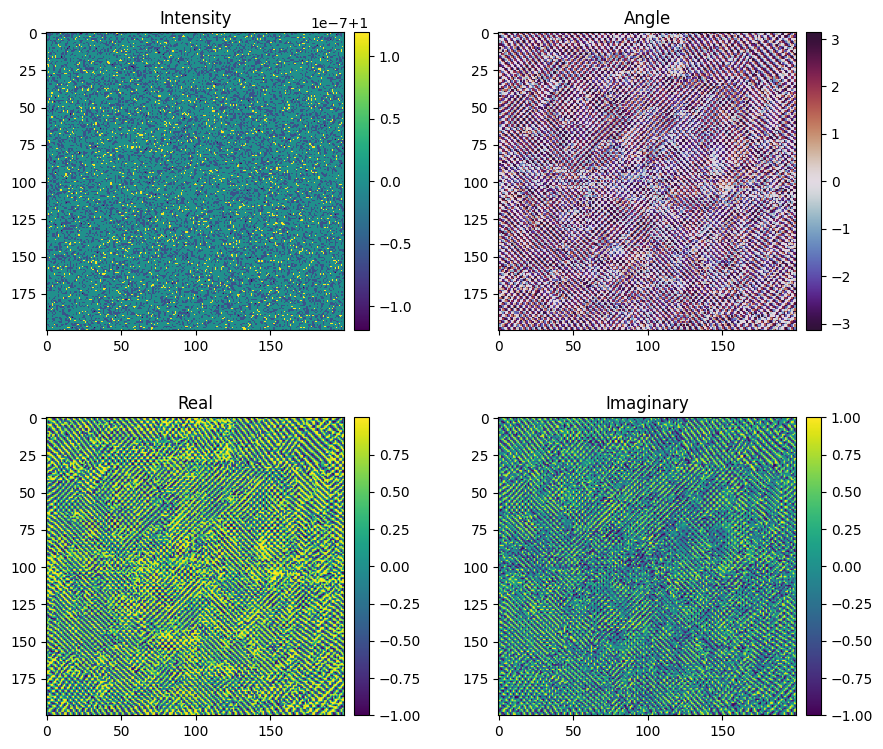

In [6]:
# display phase mask
wp = onn.phase.w_p
mask_phase = torch.sigmoid(wp) * 1.999 * math.pi
mask_complex = torch.complex(torch.cos(mask_phase), torch.sin(mask_phase))

plot_complex_image(mask_complex[0].detach().numpy())

#### image pass through model

In [7]:
dimension = 200

# hyperparameters for training and testing set
num_training_set = 50000
num_testing_set = 10000
shape_size = 0
canvas_color = 0
fill = 1


# define dataset and data loader
train_dataset = TwoPaddedRotationShapesDataset(dimension, shape_size=shape_size, length=num_training_set, canvas_color=canvas_color, fill=fill)
train_loader = DataLoader(train_dataset, batch_size=20, num_workers=6, shuffle=False)

test_dataset = TwoPaddedRotationShapesDataset(dimension, shape_size=shape_size, length=num_testing_set, canvas_color=canvas_color, fill=fill)
test_loader = DataLoader(test_dataset, batch_size=2, num_workers=6, shuffle=False)

In [8]:
X_train_dummy, y_train_dummy = create_dummy_sample(train_loader, 10)
X_train_dummy.shape, y_train_dummy.shape

(torch.Size([10, 200, 200]), torch.Size([10, 2]))

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
onn.to(device)


X_ = X_train_dummy.to(device)

output_field = onn(X_)

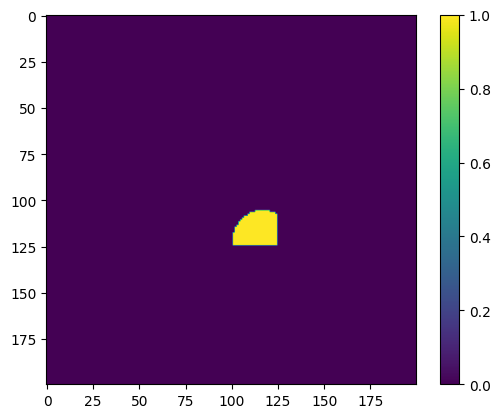

In [10]:
plt.imshow(X_train_dummy[1])
plt.colorbar()

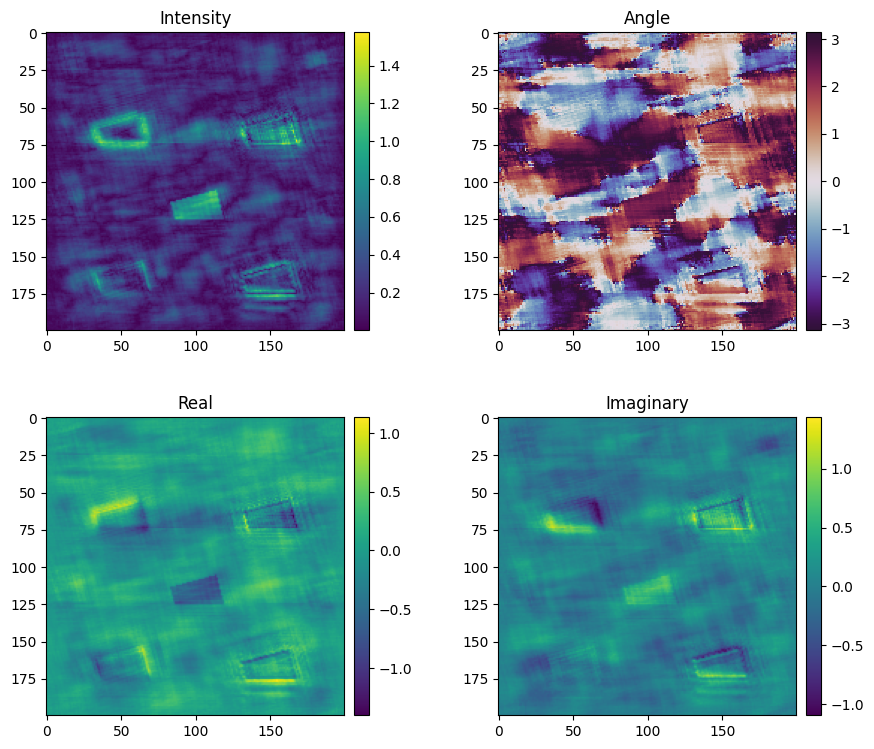

In [24]:
plot_complex_image(output_field[4].cpu().detach().numpy())

##### check impulse image

In [12]:
# define the impulse function
def impulse_function(dimension):
    image = np.zeros((1, dimension, dimension))
    image[0, dimension//2, dimension//2] = 1
    image = torch.tensor(image, dtype=torch.complex64)
    return image

In [13]:
impulse = impulse_function(200).to(device)
impulse.shape, impulse.device

(torch.Size([1, 200, 200]), device(type='cuda', index=0))

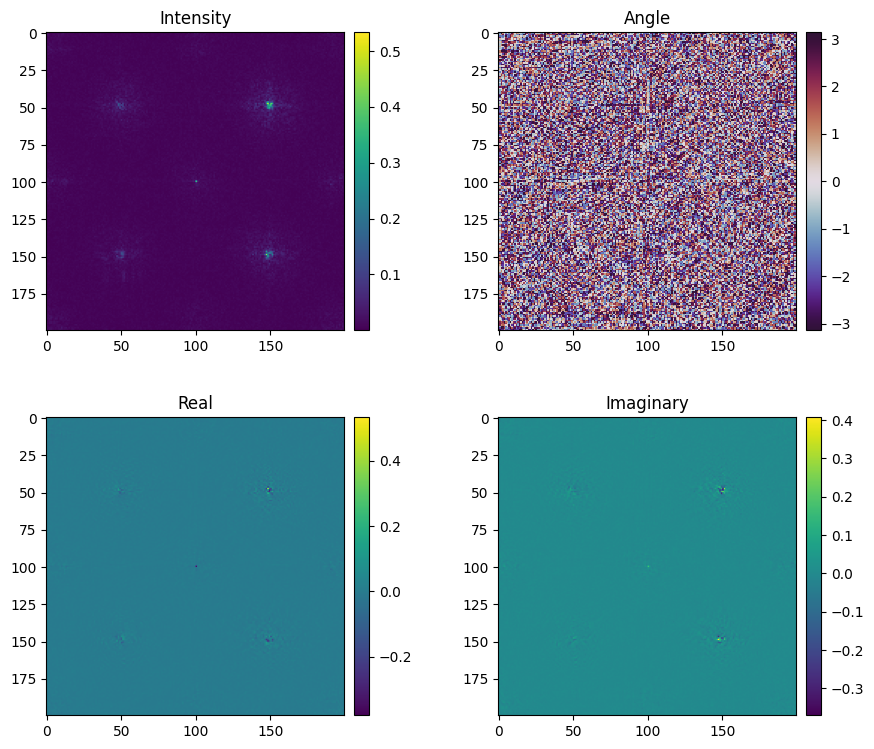

In [14]:
# pass impulse image through the network
output_field_impulse = onn(impulse)

plot_complex_image(output_field_impulse[0].cpu().detach().numpy())

### test model

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

In [16]:
model_test_results = test(model=model,
                          loss_fn=loss_fn,
                          test_dataloader=test_loader,
                          device=device)

Test loss: 0.01294 | Test acc: 1.00



In [17]:
# check DR
dr = model.dr
cropped_imgs = dr(output_field)

In [18]:
cropped_imgs.shape

torch.Size([10, 4, 50, 50])

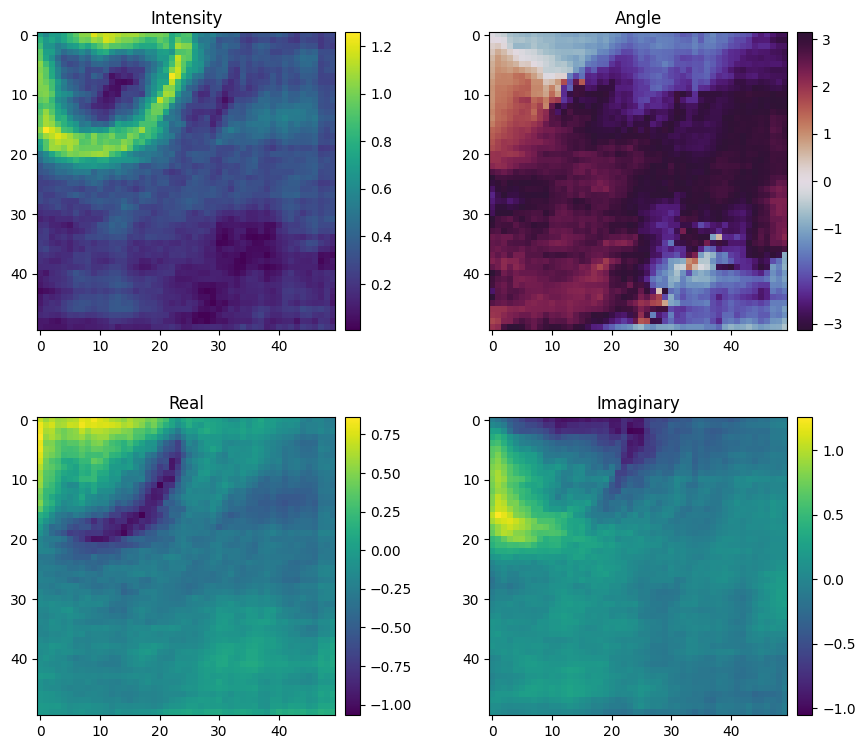

In [19]:
plot_complex_image(cropped_imgs[1][0].cpu().detach().numpy())